<a href="https://colab.research.google.com/github/dschlesinger/experiments/blob/main/gpt-lens/GPT_Lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT Lens

### Utils

In [1]:
import torch, numpy as np, transformers, os, sys, math, matplotlib.pyplot as plt, sklearn
import torch.nn.functional as F

from typing import *
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

In [24]:
# Cool chart with boxes

# From GPT
def plot_token_heatmap(tokens: List[List[str]], scores: Union[np.ndarray, torch.Tensor],
                       input_tokens: Optional[List[str]] = None,
                       output_tokens: Optional[List[str]] = None,
                       cmap: str = "coolwarm",
                       colorbar_label: str = "Activation",
                       highlight_mask: Optional[Union[np.ndarray, torch.Tensor]] = None,
                       figsize_per_token: float = 0.8) -> None:
    """
    Visualize a heatmap of token scores like in attention/activation maps.

    Args:
        tokens: 2D list of predicted tokens per layer (num_layers x seq_len)
        scores: 2D array of floats, shape = (num_layers, seq_len)
        input_tokens: List of input tokens to show along the top
        output_tokens: List of output tokens (decoded from predictions) to show along the bottom
        cmap: Matplotlib colormap to use
        colorbar_label: Label for colorbar
        highlight_mask: Optional bool array of same shape as `scores` to outline certain cells
        figsize_per_token: Controls overall figure size
    """

    # Convert PyTorch to NumPy if needed
    if isinstance(scores, torch.Tensor):
        scores = scores.detach().cpu().numpy()
    if highlight_mask is not None and isinstance(highlight_mask, torch.Tensor):
        highlight_mask = highlight_mask.detach().cpu().numpy()


    num_rows, num_tokens = scores.shape
    assert all(len(row) == num_tokens for row in tokens), "Each token row must match score width"

    fig, ax = plt.subplots(figsize=(figsize_per_token * num_tokens, figsize_per_token * num_rows))

    norm = plt.Normalize(vmin=np.min(scores), vmax=np.max(scores))
    cmap_obj = plt.get_cmap(cmap)

    for i in range(num_rows):
        for j in range(num_tokens):
            token = tokens[i][j]
            val = scores[i, j]
            color = cmap_obj(norm(val))

            # Draw box
            rect = plt.Rectangle((j, num_rows - i - 1), 1, 1, facecolor=color,
                                 edgecolor='black', linewidth=1)
            ax.add_patch(rect)

            # Optional thick border for highlight
            if highlight_mask is not None and highlight_mask[i, j]:
                rect_highlight = plt.Rectangle((j, num_rows - i - 1), 1, 1,
                                               facecolor='none', edgecolor='black', linewidth=2)
                ax.add_patch(rect_highlight)

            # Token text
            ax.text(j + 0.5, num_rows - i - 0.5, token,
                    ha='center', va='center', fontsize=8, color='black')

    # Axes cleanup
    ax.set_xlim(0, num_tokens)
    ax.set_ylim(0, num_rows)
    ax.set_xticks(np.arange(num_tokens) + 0.5)
    ax.set_yticks(np.arange(num_rows) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(num_rows)][::-1])  # Y-axis: 1 to n top to bottom
    ax.set_xticklabels([])  # Remove mid-grid tick labels
    ax.set_aspect('equal')

    # Add input/output labels above/below plot
    if input_tokens:
        for j, token in enumerate(input_tokens):
            ax.text(j + 0.5, num_rows + 0.2, token, ha='center', va='bottom', fontsize=8, color='blue', rotation=45)
    if output_tokens:
        for j, token in enumerate(output_tokens):
            ax.text(j + 0.5, -0.2, token, ha='center', va='top', fontsize=8, color='green', rotation=45)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label(colorbar_label)

    plt.tight_layout()
    plt.show()


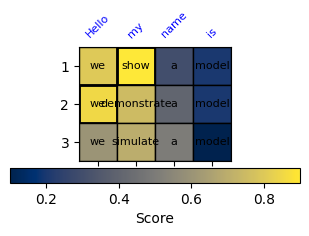

In [25]:
tokens = [
    ["we", "show", "a", "model"],
    ["we", "demonstrate", "a", "model"],
    ["we", "simulate", "a", "model"]
]
scores = np.array([
    [0.8, 0.9, 0.3, 0.2],
    [0.85, 0.75, 0.4, 0.2],
    [0.6, 0.7, 0.5, 0.1],
])

highlight_mask = (scores > 0.8)

plot_token_heatmap(tokens, scores, input_tokens=["Hello", "my", "name", "is"], cmap="cividis", colorbar_label="Score", highlight_mask=highlight_mask)

### Load GPT2

In [26]:
from transformers import AutoTokenizer, AutoModelForCausalLM

class GPT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
        self.model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
        self.model.eval()

        self.tokenizer.pad_token = self.tokenizer.eos_token

    def next_token(self, input_text) -> str:

      inputs = self.tokenizer(
            input_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
        ).to(device)

      with torch.no_grad():
        outputs = self.model(**inputs)

        next_token_id = outputs.logits[0, -1, :].argmax(dim=-1).item()

      next_token = self.tokenizer.decode([next_token_id], skip_special_tokens=True)

      return next_token

    def forward(self, input_text):

        inputs = self.tokenizer(
            input_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
        ).to(device)

        with torch.no_grad():

          outputs = self.model(**inputs, output_hidden_states=True)

        hidden_states = outputs.hidden_states

        return torch.stack(hidden_states)

model = GPT()
hidden_states = model(["Hello", "My name is"])

# (#layers, #batch, #tokens, embedding_dim)
hidden_states.shape

torch.Size([13, 2, 3, 768])

In [27]:
# Get unembedding matrix
U = model.model.lm_head.weight

model.tokenizer.decode((U @ torch.randn((768)).to(device)).argmax().item())

'taboola'

### Using Softmax Confidence

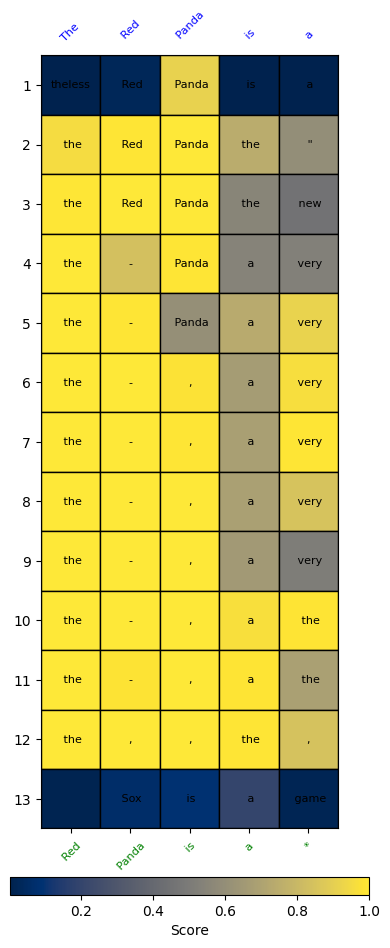

In [34]:
sentence = "The Red Panda is a"

def get_unembedding(sentence: str) -> Tuple[List[str], torch.Tensor]:

  tokens = [model.tokenizer.decode(t) for t in model.tokenizer(sentence).input_ids]

  hs = model(sentence)

  # (13, 1, x, 768) @ (50257, 768) -> (13, x, 50257)
  return tokens, hs.squeeze(1) @ U.T.unsqueeze(0)

tokens, logits = get_unembedding(sentence)

values, indices = logits.softmax(dim=-1).topk(1, dim=-1)

top_tokens = [
    [model.tokenizer.decode(i.item()) for i in r] for r in indices
]

plot_token_heatmap(top_tokens, values.squeeze(-1), input_tokens=tokens, output_tokens=tokens[1:] + ['*'], figsize_per_token=0.8, cmap="cividis", colorbar_label="Score")

### Using KL Divergence (From Output)

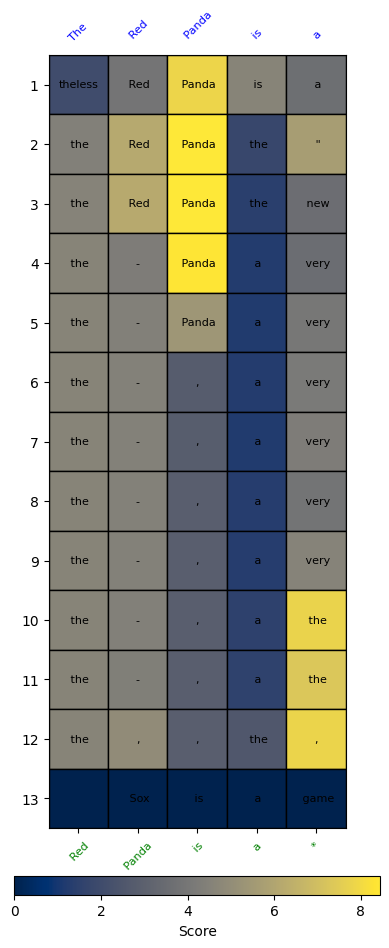

In [169]:
sentence = "The Red Panda is a"

def kl_from(sentence, layer: int) -> None:

  tokens, logits = get_unembedding(sentence)

  out_embedding = logits.softmax(dim=-1)

  output_dist = out_embedding[layer]

  values, indices = out_embedding.topk(1, dim=-1)

  top_tokens = [
      [model.tokenizer.decode(i.item()) for i in r] for r in indices
  ]

  # (x, 50257), (13, x, 50257) -> (13, 5)
  kl = F.kl_div(output_dist.log(), out_embedding, reduction='none').sum(dim=-1)

  plot_token_heatmap(top_tokens, kl, input_tokens=tokens, output_tokens=tokens[1:] + ['*'], figsize_per_token=0.8, cmap="cividis", colorbar_label="Score")

kl_from(sentence, -1)

### Using KL Divergence (From Input)

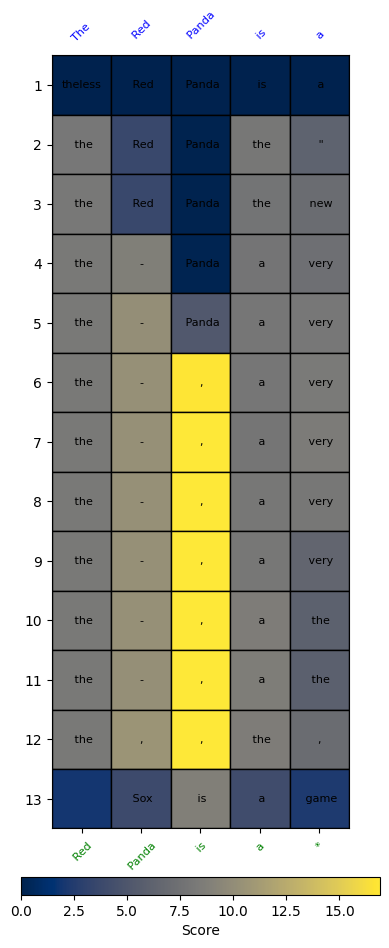

In [170]:
sentence = "The Red Panda is a"

kl_from(sentence, 0)